In [1]:
import warnings
warnings.filterwarnings('ignore')

import collections
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Spectral")
from matplotlib.colors import ListedColormap

params = {
    'legend.fontsize': '15',
    'figure.figsize': (15, 8),
     'axes.labelsize': '20',
     'axes.titlesize':'30',
     'xtick.labelsize':'18',
     'ytick.labelsize':'18',
}
plt.rcParams.update(params)

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Create dataset

##### Driver

In [20]:
samples = 60
centers = 2
features = 2
state = 11
center = 7.5

In [21]:
x,y = make_blobs(
    n_samples=samples,
    centers=centers,
    n_features=features,
    random_state=state,
    center_box=(-center, center)
)

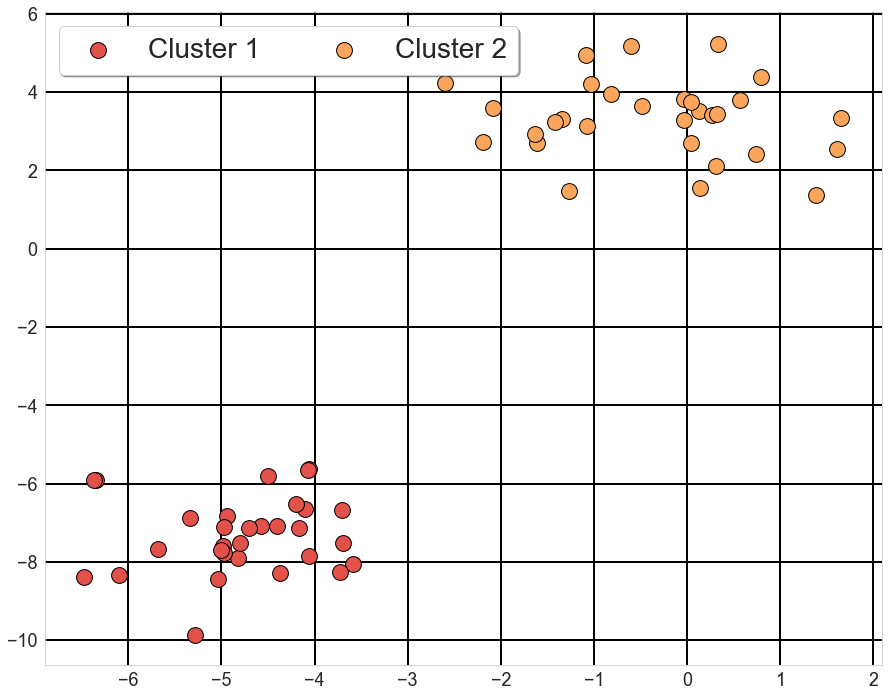

In [22]:
fig = plt.figure(figsize=(15,12))
cmap = ListedColormap(sns.color_palette("magma", 4).as_hex())
plt.scatter(x=x[:, 0][y==0], y=x[:, 1][y==0], s=250, edgecolors='k')
plt.scatter(x=x[:, 0][y==1], y=x[:, 1][y==1], s=250, edgecolors='k')
plt.grid(color='black', linestyle='-', linewidth=2)
plt.legend(labels=["Cluster 1", "Cluster 2"],
           loc=0, ncol=2, fancybox=True, shadow=True, fontsize=28)
plt.show()

### Reformat for qiskit model

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=state)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=state*4)

In [24]:
labels = [0, 1]
x_training, x_testing, x_validating = {}, {}, {}

x_training[0] = x_train[y_train==0]
x_training[1] = x_train[y_train==1]
x_testing[0] = x_test[y_test==0]
x_testing[1] = x_test[y_test==1]
x_validating[0] = x_val[y_val==0]
x_validating[1] = x_val[y_val==1]

y_training, y_testing, y_validating = {}, {}, {}
y_training[0] = y_train[y_train==0]
y_training[1] = y_train[y_train==1]
y_testing[0] = y_test[y_test==0]
y_testing[1] = y_test[y_test==1]
y_validating[0] = y_val[y_val==0]
y_validating[1] = y_val[y_val==1]

In [25]:
x_validation = np.array(list(x_validating[0])+list(x_validating[1])) # datapoints[0]
y_validation = np.array(list(y_validating[0])+list(y_validating[1])) # datapoints[1]

In [26]:
y_validation, len(x_validation)

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]), 10)

# Train Qiskit VQC on sample data

In [27]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

In [28]:
seed = 10599
aqua_globals.random_seed = seed
optimizer = SPSA(maxiter=60, c0=1.0, skip_calibration=True)
feature_map = ZZFeatureMap(feature_dimension=features, reps=2)
var_form = TwoLocal(features, ['ry', 'rz'], 'cz', reps=3)


vqc = VQC(
    optimizer,
    feature_map,
    var_form,
    x_training,
    x_testing,
    x_validation
)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqc.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(y_validation, vqc.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == y_validation)/len(predicted_labels)}%')

Testing success ratio: 0.5

Prediction from datapoints set:
  ground truth: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
  prediction:   [0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
  success rate: 30.0%


# Apply rotation to sample data and retrain

In [29]:
def rotate(origin, point, angle):
    import math
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [30]:
x2 = np.c_[[np.array(rotate([0,0], point, 65)) for point in x]]

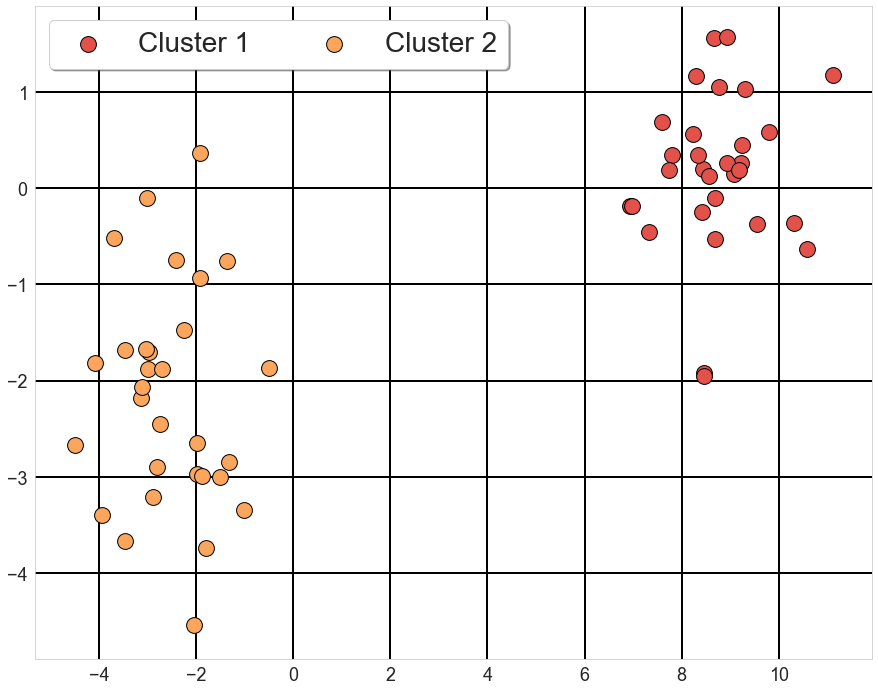

In [31]:
fig = plt.figure(figsize=(15,12))
cmap = ListedColormap(sns.color_palette("magma", 4).as_hex())
plt.scatter(x=x2[:, 0][y==0], y=x2[:, 1][y==0], s=250, edgecolors='k')
plt.scatter(x=x2[:, 0][y==1], y=x2[:, 1][y==1], s=250, edgecolors='k')
plt.grid(color='black', linestyle='-', linewidth=2)
plt.legend(labels=["Cluster 1", "Cluster 2"],
           loc=0, ncol=2, fancybox=True, shadow=True, fontsize=28)
plt.show()

### Reformat rotated samples for Qiskit model

In [32]:
#! change x to x2 for the rotated matrix
x_train, x_test, y_train, y_test = train_test_split(x2, y, test_size=0.33, random_state=state)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=state*4)

In [33]:
labels = [0, 1]
x_training, x_testing, x_validating = {}, {}, {}

x_training[0] = x_train[y_train==0]
x_training[1] = x_train[y_train==1]
x_testing[0] = x_test[y_test==0]
x_testing[1] = x_test[y_test==1]
x_validating[0] = x_val[y_val==0]
x_validating[1] = x_val[y_val==1]

y_training, y_testing, y_validating = {}, {}, {}
y_training[0] = y_train[y_train==0]
y_training[1] = y_train[y_train==1]
y_testing[0] = y_test[y_test==0]
y_testing[1] = y_test[y_test==1]
y_validating[0] = y_val[y_val==0]
y_validating[1] = y_val[y_val==1]

In [34]:
x_validation = np.array(list(x_validating[0])+list(x_validating[1])) # datapoints[0]
y_validation = np.array(list(y_validating[0])+list(y_validating[1])) # datapoints[1]

In [38]:
seed = 10599
aqua_globals.random_seed = seed
optimizer = SPSA(maxiter=60, c0=1.0, skip_calibration=True)
feature_map = ZZFeatureMap(feature_dimension=features, reps=2)
var_form = TwoLocal(features, ['ry', 'rz'], 'cz', reps=3)


vqc = VQC(
    optimizer,
    feature_map,
    var_form,
    x_training,
    x_testing,
    x_validation
)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqc.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(y_validation, vqc.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == y_validation)/len(predicted_labels)}%')

Testing success ratio: 0.5

Prediction from datapoints set:
  ground truth: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
  prediction:   [1, 1, 1, 0, 0, 0, 1, 0, 0, 1]
  success rate: 40.0%
